ULA iter    0, grad_norm=3.397e+06, sample_mean=1.232e-01, sample_std=1.736e-01
ULA iter   25, grad_norm=3.642e+05, sample_mean=4.574e+01, sample_std=7.027e+01
ULA iter   50, grad_norm=7.949e+04, sample_mean=4.901e+01, sample_std=7.947e+01
ULA iter   75, grad_norm=2.188e+04, sample_mean=4.925e+01, sample_std=8.139e+01
ULA iter  100, grad_norm=7.054e+03, sample_mean=4.926e+01, sample_std=8.188e+01
ULA iter  125, grad_norm=4.101e+03, sample_mean=4.926e+01, sample_std=8.202e+01
ULA iter  150, grad_norm=3.776e+03, sample_mean=4.926e+01, sample_std=8.205e+01
ULA iter  175, grad_norm=3.739e+03, sample_mean=4.926e+01, sample_std=8.206e+01
ULA iter  200, grad_norm=3.748e+03, sample_mean=4.926e+01, sample_std=8.207e+01
ULA iter  225, grad_norm=3.738e+03, sample_mean=4.926e+01, sample_std=8.207e+01
100


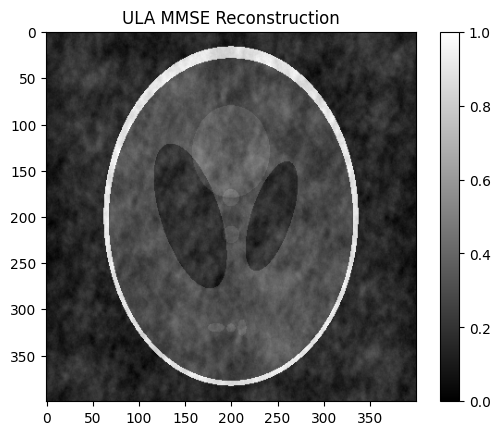

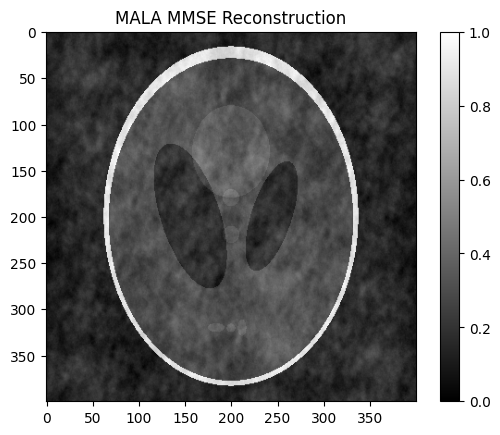

In [ ]:
import sys
import os

# Add the parent directory of MAP to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), r"C:\Users\kostanjsek\bachelor_project"))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


import torch
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
)
from MAP.map_tv_minimize import MAPEstimator
from MMSE.mmse_ula import MMSEEstimatorULA
# from MMSE.metropolis_hastings import MHEstimator
from MMSE.mmse_mala import MMSEEstimatorMALA



# load iamge
shepp_logan = ski.data.shepp_logan_phantom()

# create mask (in the F domain)
column_mask = SimpleMask(2).mask_columns(shepp_logan)
row_mask = SimpleMask(3).mask_rows(shepp_logan) 
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask("gaussian", 2, seed=30).generate(shepp_logan.shape)
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, acceleration=8, seed=30).get_mask()

# the 'actual' measurement
y = centered_bernoulli_mask* np.fft.fft2(shepp_logan)

y_norm = y / np.max(y)


#mala_estimator = MMSEEstimatorMALA(centered_bernoulli_mask, y, 0.95, 200, 100e-2, 1e-9, 250, 2, 100)
#malatry_estimator = MMSEEstimatorMALAtry(centered_bernoulli_mask,y,0.95,200, 1e-3,200, 3, 100)
mala_estimator = MMSEEstimatorMALA(centered_bernoulli_mask, 0.1, 2, 100e-2, 1e-3, 50, 2, 100)
ula_estimator = MMSEEstimatorULA(centered_bernoulli_mask, 0.1, 2, 100e-2, 1e-3, 50, 2, 100)

# ula plot
plt.imshow(ula_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("ULA MMSE Reconstruction")
plt.colorbar()
plt.show()

# mala plot
plt.imshow(mala_estimator.compute_mmse_estimate(y), cmap="gray")
plt.title("MALA MMSE Reconstruction")
plt.colorbar()
plt.show()

# plt.imshow(np.abs(malasimple_estimator.compute_mmse_estimate(y) - ula_estimator.compute_mmse_estimate(y)), cmap="gray")
# plt.title("Difference")
# plt.colorbar()
# plt.show()


In [ ]:
class MMSEEstimatorULA:
    def __init__(self, M, sigma, lambda_, eps, ula_step_size, burn_in, thin, num_samples):
        self.ula_step_size = ula_step_size
        self.burn_in = burn_in
        self.thin = thin
        self.num_samples = num_samples
        self.map_estimator = MAPEstimator(M, sigma, lambda_, eps) # MAP instance for gradient computations

    def ula_sampling(self, y, x_init=None):

        if x_init is None:
            x = np.real(np.fft.ifft2(y))
        else:
            x = np.array(x_init, dtype=float)

        samples_kept = []

        for i in range(self.burn_in + self.num_samples * self.thin):

            grad = (self.map_estimator.data_fidelity_gradient(x, y) + self.map_estimator.lambda_ * self.map_estimator.huber_tv_subgradient(x))
            
            noise = np.random.randn(*x.shape) * np.sqrt(2.0 * self.ula_step_size)

            x = x - grad * self.ula_step_size + noise # ULA update: x_{t+1} = x_t - step * ∇U(x_t) + sqrt(2*step)*N(0, I)*

            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print("NaN/Inf detected at iteration", i)
                break

            if i >= self.burn_in and (i - self.burn_in) % self.thin == 0:
                samples_kept.append(np.copy(x))

        return samples_kept
    
    def compute_mmse_estimate(self, y, x_init=None):
        """
        Compute MMSE estimate = mean over ULA posterior samples.
        """
        samples = self.ula_sampling(y)
        x_mmse = np.mean(samples, axis=0)
        normalized_mmse = (x_mmse - x_mmse.min()) / (x_mmse.max() - x_mmse.min())
        return normalized_mmse